This notebook demonstrates how to use a common method found in the literature of airfoil optimization, parametric optimization. 
To this end we try gradient-based as well as gradient-free methods from the scipy optimization toolbox and use virtual displacements to allow the rapid the evaluation of the different geometries.

Do not take this notebook as a best-practice notebook for gradient-based optimization - unless you for some reason need or prefer the constraint of a PARSEC parameter space.
With gradient based optimization, there are better ways to avoid the pitfalls of airfoil optimization [1] than to severely restrict the design space using parametrization, e.g. constraining the resulting geometry to avoid high curvature.

Here, we restrict the design space to a PARSEC [2] parametrization and only look for symmetric airfoils, which reduces the parameter space to 5 values. 
This is a problem that can be solved by gradient-free optimizers as well as by gradient based solvers, even with the aid of finite-differences, without testing my patience too much.
We compare (analytical) gradient based optimization with a gradient-free optimizer, and subsequently build the Pareto-front of area against drag coefficient for different airfoil areas.
That is we have two goals (drag and area) and we find the subspace of parameters for which we cannot improve drag without decreasing area.

There are a lot of cases in the literature that are concerned with the PARSEC parameterization and optimizing airfoils.
For example, in [4] the PARSEC parametrization is used together with XFOIL [5] to find optima under different constraints and weights using heuristic search methods. 
For other, similar works see the references therein. 

In [1]:
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import numpy as np
from numpy import pi
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 6]

In [3]:
# The code to generate parsec airfoils has been copied from 
#     https://github.com/dqsis/parsec-airfoils 
# by Dimitrios Kiousis. The code is part of the git repository of this notebook.
from parsec import parsec_airfoil

# Sample coefficients (NACA0012)
# The parameters are from [3]
rle = .015
x_pre = 0.29663
y_pre = -0.06002
d2ydx2_pre = 0.45150
th_pre = 10*pi/180
x_suc = 0.29663
y_suc = 0.06002
d2ydx2_suc = -0.45150
th_suc = -10*pi/180
yte = .0
N = 200
param = np.asarray([rle,x_pre,y_pre,d2ydx2_pre,th_pre,x_suc,y_suc,d2ydx2_suc,th_suc])

Base = parsec_airfoil(N,yte, rle,
                   x_pre, y_pre, d2ydx2_pre, th_pre,
                  x_suc, y_suc, d2ydx2_suc, th_suc)
BaseAirfoil = vft.repanel(Base[:,::-1],N,LEFAC=4)

We not only need the PARSEC parameter definition of an airfoil but also the gradients of all quantities of interest with respect to the parameter.
Viiflow returns the paraemters with respect to the virtual displacements, that is the shift of the geometry normal to its current surface at every discretization point.
To calculate the gradient with respect to the PARSEC parameters, we use the viiflowtools function `virtual_displacement_from_geometry(Base,Target)`, which calculates the displacement given a desired shape (Base) from a given shape (Target).
The gradient is then given by finite differences of this function.

For symmetric airfoils, the parameters needed are reduced to 5.

In [4]:
# Build airfoil from parameters and, if needed, calculate finite difference gradient of displacement-from-parameters
def dDeltadParam(param,N,BaseAirfoil,calc_gradient):
    tol = 1e-4
    scale = np.asarray([0.01,0.5,0.05,0.5,1,0.5,0.05,0.5,1])
    Airfoil0 = parsec_airfoil(N,0,*param)[:,::-1]
    [delta0,Shape] = vft.virtual_displacement_from_geometry(BaseAirfoil,Airfoil0)
    # Smooth a bit
    delta = delta0.copy()
    N = len(delta)
    delta[1:N-1] = 1/3*(delta0[0:N-2]+delta0[1:N-1]+delta0[2:N])
    if calc_gradient:
        dDeltadparam = np.zeros((BaseAirfoil.shape[1],9))
        for k in range(9):
            for s in [-1,1]:
                dparam = param.copy()
                dparam[k]+=s*tol*scale[k]
                Airfoil1 = parsec_airfoil(N,0,*dparam)[:,::-1]
                [delta01,_] = vft.virtual_displacement_from_geometry(BaseAirfoil,Airfoil1)
                delta1 = delta01.copy()
                delta1[1:N-1] = 1/3*(delta01[0:N-2]+delta01[1:N-1]+delta01[2:N])
                dDeltadparam[:,k] += 0.5*s*(delta1-delta)/tol/scale[k]
        return [delta,dDeltadparam,Shape,Airfoil0]
    else:
        return [delta,None,Shape,Airfoil0]

# For symmetric airfoils
def dDeltadParamSymmetric(paramSym,N,BaseAirfoil,calc_gradient):
    param = np.r_[paramSym,paramSym[1],-paramSym[2],-paramSym[3],-paramSym[4]]
    [delta,dDeltadparam,Shape,Airfoil0] = dDeltadParam(param,N,BaseAirfoil,calc_gradient)
    if calc_gradient:
        dParamdParamIn = np.r_[np.eye(5),np.c_[np.zeros((4,1)),np.diag([1,-1,-1,-1])]]
        dDeltadparam = dDeltadparam@dParamdParamIn
        return [delta,dDeltadparam,Shape,Airfoil0]
    else:
        return [delta,None,Shape,Airfoil0]
    
# This function calculates the cross-sectional area of an airfoil (polygon formula)
# We need that later in our optimization function
def AreaPoly(p,vd=None):
    BASE = np.asarray(p.foils[0].X)
    N = BASE.shape[1]
    X0 = BASE[0,:]
    Y0 = BASE[1,:]
    dX = np.asarray(p.foils[0].normals[0,:]).flatten()
    dY = np.asarray(p.foils[0].normals[1,:]).flatten()
    if not vd is None:
        XN = X0+vd*(dX)
        YN = Y0+vd*(dY)
    else:
        XN = X0
        YN = Y0
    Area = 0.5*np.dot((XN[1::]+XN[0:N-1]),(YN[1::]-YN[0:N-1]))
    Area_vd = np.zeros(N)
    Area_vd[1::] = 0.5*(dX[1::])*(YN[1::]-YN[0:N-1]) + 0.5*(dY[1::])*(XN[1::]+XN[0:N-1]) 
    Area_vd[0:N-1] += 0.5*(dX[0:N-1])*(YN[1::]-YN[0:N-1]) - 0.5*(dY[0:N-1])*(XN[1::]+XN[0:N-1]) 
    return (Area,Area_vd)

In the following section scipys optimization routines `SLSQP`(gradient based Newton-type method) and `Nelder-Mead`(Derivative-free method) are used to optimize the parameters for minimal drag for a symmetric airfoil.

In [5]:
from scipy import optimize

# Setup viiflow and solve NACA0012
# We re-use the viiflow object p and bl
setup = vf.setup(Re=1e6,Ma=0.0,Ncrit=9,Alpha=0,Gradients=True,Silent=True,Tolerance=1e-8)
(p,bl,x) = vf.init(BaseAirfoil,setup)
x,flag,res,grad,_ = vf.iter(x,bl,p,setup,None,None,None)
x0 = x

# This function is optimized
def evalFun(paramOpt,A0,calc_gradient,x0):
    global bl,p
    
    [delta,dDeltadparam,_,_] = dDeltadParamSymmetric(paramOpt,N,BaseAirfoil,calc_gradient)
    setup.Gradients = True
    x,flag,_,_,gradients = vf.iter(x0,bl,p,setup,None,None,delta)
    cd = bl[0].CD
    
    # Area
    areaWeight = 10
    A,A_vd = AreaPoly(p,delta)
    Adif = areaWeight*(A-A0)**2/A0
    Adif_vd = areaWeight*2*(A-A0)/A0*A_vd
    
    # If unconverged, let the optimizer know this is not a valid step
    if flag<=0:
        cd = np.inf
        (p,bl,_) = vf.init(BaseAirfoil,setup)
        x,flag,_,_,gradients = vf.iter(x0,bl,p,setup)
    grad = None
    gradA = None
    gradCD = None
    if calc_gradient:
        grad = np.asarray((gradients.total.cd_vd+Adif_vd)@dDeltadparam).ravel()
        gradA = (A_vd)@dDeltadparam
        gradCD = np.asarray((gradients.total.cd_vd)@dDeltadparam).ravel()

    # We don't really need all these outputs
    # But I did need them while debugging the different parts of our function or plotting
    return [cd+Adif, grad, cd, A, gradA,gradCD]

# This function is called in addition after a successful step
# Here we could also use plot callbacks
# Because I am not sure what "z" the scipy optimization routine evaluated last, and therefore what bl[0].CD contains,
# the drag is re-evaluated given the current iterate.
def iterfun(z,history,calc_gradient,x0):
    global lines,bl,p,fig,ax,cdmin
    [delta,_,Shape,_] = dDeltadParamSymmetric(z,N,BaseAirfoil,False)
    setup.Gradients = True
    x,flag,_,_,_ = vf.iter(x0,bl,p,setup,None,None,delta)
    if flag:
        history.append(bl[0].CD)
    
# Reduced parameter set and bounds on parameters
paramOpt = (param[0:5].copy())
bounds = [(0.001,0.1),(0.05,0.95),(-.5,-.0001),(0.01,2),(0,20*pi/180)]

# Solve and collect history of iterates
Area0,_ = AreaPoly(p)
cd0 = bl[0].CD
historyAnalytical = [cd0]
resultAnalytical = optimize.minimize(lambda z: evalFun(z,Area0,True,x0)[0:2], paramOpt, method='SLSQP', jac= True,options={"ftol":1e-13},bounds=bounds,callback=lambda z: iterfun(z,historyAnalytical,True,x0))
iterfun(resultAnalytical.x,historyAnalytical,True,x0)
print(resultAnalytical)
historyHeuristic = [cd0]
resultHeuristic = optimize.minimize(lambda z: evalFun(z,Area0,False,x0)[0], paramOpt, method='Nelder-Mead',options={"ftol":1e-9},bounds=bounds,callback=lambda z: iterfun(z,historyHeuristic,False,x0))
iterfun(resultHeuristic.x,historyHeuristic,False,x0)
print(resultHeuristic)

 xi=0.560703,delta=0.011325,theta=0.003950,ue=0.881631,n/ct=0.166943
 xi=0.560635,delta=0.032518,theta=0.012470,ue=0.702663,n/ct=0.287150
 xi=0.591845,delta=0.001522,theta=0.001461,ue=0.776645,n/ct=0.058117


     fun: 0.004104548418900397
     jac: array([ 1.52408999e-04,  4.20374843e-06, -1.80483504e-04,  1.54485555e-06,
       -8.93343665e-08])
 message: 'Optimization terminated successfully'
    nfev: 75
     nit: 50
    njev: 50
  status: 0
 success: True
       x: array([ 0.00967263,  0.3590967 , -0.05753972,  0.44539846,  0.28926953])


c:\users\maxra\scoop\apps\python\3.8.7\lib\site-packages\scipy\optimize\_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


 final_simplex: (array([[ 0.0096723 ,  0.35954629, -0.05754031,  0.4454545 ,  0.28933979],
       [ 0.00967125,  0.35955096, -0.05754066,  0.44545755,  0.28932395],
       [ 0.00967174,  0.35952748, -0.05754037,  0.44544011,  0.28931499],
       [ 0.00967187,  0.35954714, -0.05754033,  0.44544563,  0.2893258 ],
       [ 0.00967623,  0.35953584, -0.05753928,  0.44538847,  0.2893397 ],
       [ 0.00967563,  0.35956261, -0.05753918,  0.44539859,  0.28934194]]), array([0.00410454, 0.00410454, 0.00410454, 0.00410454, 0.00410454,
       0.00410454]))
           fun: 0.004104544916144702
       message: 'Optimization terminated successfully.'
          nfev: 534
           nit: 325
        status: 0
       success: True
             x: array([ 0.0096723 ,  0.35954629, -0.05754031,  0.4454545 ,  0.28933979])


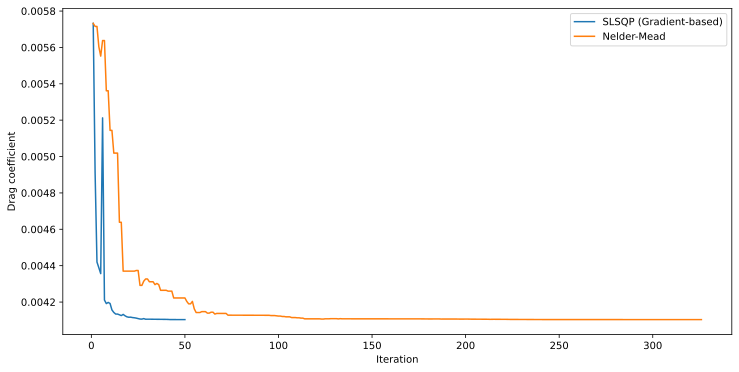

In [6]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(1,len(historyAnalytical)+1),historyAnalytical,label="SLSQP (Gradient-based)")
ax.plot(np.arange(1,len(historyHeuristic)+1),historyHeuristic,label="Nelder-Mead")
ax.legend()
ax.set_ylabel("Drag coefficient")
ax.set_xlabel("Iteration");

Both methods arrive at (very) similar optimization points.
However, the gradient-free method spend a lot more iterates and function evaluations arriving there.

In [7]:
# Run optimization over several Areas and Reynolds numbers
NSteps = 40
setup.Tolerance = 1e-8
setup.Itermax = 100
results = {}
for RE in [2e5,5e5,1e6]:
    setup.Re = RE
    Area0,_ = AreaPoly(p)
    AreaFac = np.r_[np.linspace(1,0.33,int(NSteps/2)),np.linspace(1,2,int(NSteps/2))]
    DragVector = np.zeros(NSteps)*np.nan
    AreaVector = np.zeros(NSteps)*np.nan
    XVector = np.zeros((5,NSteps))*np.nan

    for k in range(NSteps):
        if AreaFac[k]==1:
            print("init")
            (p,bl,x0) = vf.init(BaseAirfoil,setup)
            x0,_,_,_,gradients = vf.iter(x0,bl,p,setup)
            param0 = paramOpt;
        resultPareto = optimize.minimize(lambda z: evalFun(z,AreaFac[k]*Area0,True,x0)[0:2], 
                                             param0, method='SLSQP', jac= True,
                                             options={"ftol":1e-9,"maxiter":300},bounds=bounds
                                            )
        if resultPareto.status==0:
            [delta,_,_,_] = dDeltadParamSymmetric(resultPareto.x,N,BaseAirfoil,True)
            (p,bl,x) = vf.init(BaseAirfoil,setup)
            x0,flag,_,_,gradients = vf.iter(x0,bl,p,setup,None,None,delta)
            if flag:
                Area,_ = AreaPoly(p,delta)
                AreaVector[k] = Area
                DragVector[k] = bl[0].CD
                XVector[:,k] = resultPareto.x
                param0 = resultPareto.x
            else:
                (p,bl,x) = vf.init(BaseAirfoil,setup)
                x0,flag,_,_,gradients = vf.iter(x0,bl,p,setup)
    results[RE] = {}
    results[RE]["Area"]=AreaVector
    results[RE]["Drag"]=DragVector
    results[RE]["X"]=XVector
    

init


 xi=0.008789,delta=0.000038,theta=0.000025,ue=3.239812,n/ct=0.000000
 xi=0.008780,delta=0.000038,theta=0.000020,ue=3.186621,n/ct=0.000005
 xi=0.008820,delta=0.000038,theta=0.000023,ue=3.226773,n/ct=0.000000
 xi=0.008715,delta=0.000037,theta=0.000020,ue=3.075725,n/ct=0.000000
 xi=0.008691,delta=0.000039,theta=0.000021,ue=2.837222,n/ct=0.000000
 xi=0.008700,delta=0.000039,theta=0.000024,ue=2.959762,n/ct=0.000000
 xi=0.008754,delta=0.000045,theta=0.000026,ue=2.404418,n/ct=0.000000
c:\users\maxra\scoop\apps\python\3.8.7\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
 xi=0.008745,delta=0.000038,theta=0.000019,ue=3.359109,n/ct=0.000000
 xi=0.072493,delta=0.000927,theta=0.000523,ue=4.145181,n/ct=0.115935
 xi=0.008411,delta=0.000044,theta=0.000021,ue=2.421269,n/ct=0.000000
 xi=0.349497,delta=0.007247,theta=0.002723,ue=1.406987,n/ct=0.170715
 

init


 xi=0.721958,delta=0.017343,theta=0.012992,ue=0.843616,n/ct=0.207908
 xi=0.640013,delta=0.012481,theta=0.004093,ue=1.370826,n/ct=0.133565
 xi=0.640017,delta=0.011128,theta=0.003858,ue=1.338798,n/ct=0.133988
 xi=0.640012,delta=0.011891,theta=0.004123,ue=1.329790,n/ct=0.134346
 xi=0.721944,delta=0.017583,theta=0.007046,ue=1.121067,n/ct=0.147314
 xi=0.721943,delta=0.018312,theta=0.013050,ue=0.871232,n/ct=0.206052
 xi=0.640027,delta=0.012573,theta=0.004690,ue=1.361543,n/ct=0.107092
 xi=0.640026,delta=0.012974,theta=0.004829,ue=1.348353,n/ct=0.106034
 xi=0.640011,delta=0.013007,theta=0.005965,ue=1.233984,n/ct=0.112508
 xi=0.721961,delta=0.020163,theta=0.009316,ue=1.123128,n/ct=0.167408
 xi=0.640008,delta=0.012615,theta=0.004422,ue=1.403268,n/ct=0.106194
 xi=0.007745,delta=0.000041,theta=0.000024,ue=2.673457,n/ct=0.000000
 xi=0.007703,delta=0.000041,theta=0.000023,ue=2.657258,n/ct=0.000000
 xi=0.007631,delta=0.000041,theta=0.000024,ue=2.680235,n/ct=0.000000
 xi=0.007710,delta=0.000041,theta=

 xi=0.007441,delta=0.000056,theta=0.000039,ue=1.519876,n/ct=0.000000
 xi=0.007467,delta=0.000056,theta=0.000030,ue=1.503340,n/ct=0.000008
 xi=0.007452,delta=0.000057,theta=0.000033,ue=1.446267,n/ct=0.000000
 xi=0.007315,delta=0.000058,theta=0.000028,ue=1.351200,n/ct=0.000007
 xi=0.007258,delta=0.000058,theta=0.000029,ue=1.354589,n/ct=0.000007
 xi=0.007260,delta=0.000058,theta=0.000030,ue=1.358279,n/ct=0.000007
 xi=0.007311,delta=0.000055,theta=0.000029,ue=1.422675,n/ct=0.000007
 xi=0.007312,delta=0.000038,theta=0.000021,ue=2.164758,n/ct=0.000000
 xi=0.007028,delta=0.000040,theta=0.000019,ue=1.991980,n/ct=0.000005
 xi=0.007025,delta=0.000041,theta=0.000021,ue=2.046364,n/ct=0.000005
 xi=0.007020,delta=0.000041,theta=0.000021,ue=1.973680,n/ct=0.000000
 xi=0.006999,delta=0.000041,theta=0.000022,ue=1.991261,n/ct=0.000000
 xi=0.007003,delta=0.000041,theta=0.000027,ue=2.121821,n/ct=0.000000
 xi=0.006432,delta=0.000055,theta=0.000030,ue=1.122220,n/ct=0.000000
 xi=0.006482,delta=0.000055,theta=

 xi=0.375636,delta=0.011643,theta=0.005935,ue=1.669736,n/ct=0.156069
 xi=0.006015,delta=0.000058,theta=0.000036,ue=1.316804,n/ct=0.000000
 xi=0.006060,delta=0.000055,theta=0.000030,ue=1.283386,n/ct=0.000000
 xi=0.006094,delta=0.000058,theta=0.000027,ue=1.237055,n/ct=0.000007
 xi=0.006107,delta=0.000060,theta=0.000034,ue=1.214170,n/ct=0.000000
 xi=0.006134,delta=0.000048,theta=0.000025,ue=1.689494,n/ct=0.000000
 xi=0.006131,delta=0.000048,theta=0.000026,ue=1.684539,n/ct=0.000000
 xi=0.006804,delta=0.000058,theta=0.000030,ue=1.389762,n/ct=0.000007
 xi=0.006803,delta=0.000058,theta=0.000031,ue=1.399648,n/ct=0.000009
 xi=0.006806,delta=0.000058,theta=0.000027,ue=1.342032,n/ct=0.000000
 xi=0.006808,delta=0.000058,theta=0.000032,ue=1.408355,n/ct=0.000000
 xi=0.006810,delta=0.000058,theta=0.000030,ue=1.374582,n/ct=0.000000
 xi=0.006810,delta=0.000059,theta=0.000028,ue=1.358765,n/ct=0.000007
 xi=0.006809,delta=0.000059,theta=0.000033,ue=1.391078,n/ct=0.000000
 xi=0.006823,delta=0.000058,theta=

init


 xi=0.545323,delta=0.008133,theta=0.004207,ue=1.177901,n/ct=0.100531
 xi=0.545316,delta=0.009207,theta=0.003135,ue=1.622939,n/ct=0.088347
 xi=0.545322,delta=0.009097,theta=0.004654,ue=1.408319,n/ct=0.095525
 xi=0.545321,delta=0.008638,theta=0.004459,ue=1.438270,n/ct=0.089483
 xi=0.545306,delta=0.008701,theta=0.004495,ue=1.404505,n/ct=0.088236
 xi=0.545299,delta=0.008394,theta=0.004365,ue=1.556344,n/ct=0.093144
 xi=0.545298,delta=0.009062,theta=0.003111,ue=1.927139,n/ct=0.089474
 xi=0.545304,delta=0.009543,theta=0.003259,ue=2.022073,n/ct=0.092535
 xi=0.545321,delta=0.010341,theta=0.003786,ue=1.980466,n/ct=0.097253
 xi=0.545321,delta=0.013786,theta=0.004432,ue=2.068310,n/ct=0.130598
 xi=0.545359,delta=0.013500,theta=0.005406,ue=1.970393,n/ct=0.138291
 xi=0.639829,delta=0.010409,theta=0.004003,ue=1.113879,n/ct=0.140971
 xi=0.833945,delta=0.006726,theta=0.004601,ue=0.773849,n/ct=0.096541
 xi=0.833945,delta=0.006626,theta=0.004722,ue=0.774044,n/ct=0.096897
 xi=0.672560,delta=0.006830,theta=

init


 xi=0.545323,delta=0.008133,theta=0.004207,ue=1.177901,n/ct=0.100531
 xi=0.545316,delta=0.009207,theta=0.003135,ue=1.622939,n/ct=0.088347
 xi=0.545322,delta=0.009097,theta=0.004654,ue=1.408319,n/ct=0.095525
 xi=0.545321,delta=0.008638,theta=0.004459,ue=1.438270,n/ct=0.089483
 xi=0.545306,delta=0.008701,theta=0.004495,ue=1.404505,n/ct=0.088236
 xi=0.545299,delta=0.008394,theta=0.004365,ue=1.556344,n/ct=0.093144
 xi=0.545298,delta=0.009062,theta=0.003111,ue=1.927139,n/ct=0.089474
 xi=0.545304,delta=0.009543,theta=0.003259,ue=2.022073,n/ct=0.092535
 xi=0.545321,delta=0.010341,theta=0.003786,ue=1.980466,n/ct=0.097253
 xi=0.545321,delta=0.013786,theta=0.004432,ue=2.068310,n/ct=0.130598
 xi=0.545359,delta=0.013500,theta=0.005406,ue=1.970393,n/ct=0.138291
 xi=0.639829,delta=0.010409,theta=0.004003,ue=1.113879,n/ct=0.140971
 xi=0.754931,delta=0.003478,theta=0.001557,ue=1.039065,n/ct=0.108262
 xi=0.787248,delta=0.005843,theta=0.002186,ue=0.984568,n/ct=0.105063
 xi=0.787249,delta=0.005840,theta=

 xi=0.264815,delta=0.003174,theta=0.001492,ue=1.767822,n/ct=0.133698
 xi=0.006406,delta=0.000006,theta=0.000003,ue=14.231481,n/ct=0.000000
 xi=0.264772,delta=0.003453,theta=0.001229,ue=1.971605,n/ct=0.116192
 xi=0.006405,delta=0.000006,theta=0.000004,ue=17.066588,n/ct=0.000001
 xi=0.006403,delta=0.000005,theta=0.000003,ue=16.335797,n/ct=0.000000
 xi=0.006400,delta=0.000005,theta=0.000003,ue=17.340151,n/ct=0.000000
 xi=0.006397,delta=0.000005,theta=0.000003,ue=15.694824,n/ct=0.000000
 xi=0.006400,delta=0.000005,theta=0.000003,ue=19.242025,n/ct=0.000000
 xi=0.006397,delta=0.000005,theta=0.000003,ue=18.270200,n/ct=0.000000
 xi=0.006392,delta=0.000005,theta=0.000003,ue=19.715627,n/ct=0.000000
 xi=0.006391,delta=0.000005,theta=0.000003,ue=19.178249,n/ct=0.000000
 xi=0.005962,delta=0.000043,theta=0.000025,ue=0.837636,n/ct=0.000000
 xi=0.006012,delta=0.000039,theta=0.000025,ue=0.922460,n/ct=0.000002
 xi=0.006474,delta=0.000030,theta=0.000016,ue=1.288823,n/ct=0.000000
 xi=0.006515,delta=0.0000

 xi=0.738570,delta=0.005839,theta=0.002998,ue=0.957403,n/ct=0.141322
 xi=0.722063,delta=0.009193,theta=0.004841,ue=0.869784,n/ct=0.171402
 xi=0.722072,delta=0.005610,theta=0.001858,ue=1.029836,n/ct=0.111118
 xi=0.722079,delta=0.008044,theta=0.003609,ue=1.024731,n/ct=0.110488
 xi=0.722075,delta=0.004916,theta=0.002187,ue=1.117429,n/ct=0.088504
 xi=0.722076,delta=0.005382,theta=0.002855,ue=0.947899,n/ct=0.095833
 xi=0.722118,delta=0.007942,theta=0.003544,ue=1.035235,n/ct=0.145725
 xi=0.722107,delta=0.008354,theta=0.004272,ue=1.033375,n/ct=0.162842
 xi=0.722104,delta=0.008208,theta=0.004395,ue=0.980605,n/ct=0.175054
 xi=0.656194,delta=0.016599,theta=0.005677,ue=1.099664,n/ct=0.166328
 xi=0.008810,delta=0.000038,theta=0.000021,ue=1.393401,n/ct=0.000005
 xi=0.008811,delta=0.000037,theta=0.000020,ue=1.398458,n/ct=0.000005
 xi=0.008811,delta=0.000037,theta=0.000018,ue=1.343675,n/ct=0.000004
 xi=0.008813,delta=0.000038,theta=0.000021,ue=1.328711,n/ct=0.000000
 xi=0.048831,delta=0.000016,theta=

 xi=0.008977,delta=0.000028,theta=0.000015,ue=1.765071,n/ct=0.000000
 xi=0.009298,delta=0.000029,theta=0.000015,ue=1.742664,n/ct=0.000000
 xi=0.006557,delta=0.000059,theta=0.000031,ue=0.509302,n/ct=0.000000
 xi=0.006035,delta=0.000041,theta=0.000020,ue=0.857556,n/ct=0.000000
 xi=0.006020,delta=0.000041,theta=0.000023,ue=0.886677,n/ct=0.000000
 xi=0.006030,delta=0.000039,theta=0.000024,ue=0.938401,n/ct=0.000000
 xi=0.006054,delta=0.000037,theta=0.000019,ue=0.932215,n/ct=0.000000
 xi=0.006045,delta=0.000044,theta=0.000024,ue=0.830716,n/ct=0.000006
 xi=0.006037,delta=0.000043,theta=0.000021,ue=0.813511,n/ct=0.000000
 xi=0.006016,delta=0.000039,theta=0.000020,ue=0.895433,n/ct=0.000005
 xi=0.006023,delta=0.000039,theta=0.000024,ue=0.937680,n/ct=0.000000
 xi=0.150826,delta=0.000122,theta=0.000066,ue=6.050539,n/ct=8.997599
 xi=0.443506,delta=0.021811,theta=0.008374,ue=1.379715,n/ct=0.220429
 xi=0.443565,delta=0.022410,theta=0.010752,ue=1.242473,n/ct=0.244246
 xi=0.443523,delta=0.022477,theta=

 xi=0.006648,delta=0.000013,theta=0.000006,ue=4.703521,n/ct=0.000001
 xi=0.006648,delta=0.000011,theta=0.000005,ue=6.136668,n/ct=0.000001
 xi=0.006648,delta=0.000013,theta=0.000006,ue=4.551916,n/ct=0.000002
 xi=0.006650,delta=0.000018,theta=0.000012,ue=3.161422,n/ct=0.000000
 xi=0.006648,delta=0.000019,theta=0.000010,ue=2.899029,n/ct=0.000002
 xi=0.006649,delta=0.000026,theta=0.000016,ue=1.976702,n/ct=0.000000
 xi=0.771194,delta=0.006070,theta=0.004894,ue=0.757511,n/ct=0.140578
 xi=0.771192,delta=0.006162,theta=0.002619,ue=1.009710,n/ct=0.109764
 xi=0.771185,delta=0.005484,theta=0.005081,ue=0.753717,n/ct=0.144096
 xi=0.771185,delta=0.005219,theta=0.003719,ue=0.830843,n/ct=0.128164
 xi=0.771186,delta=0.005223,theta=0.003722,ue=0.831113,n/ct=0.128140
 xi=0.771187,delta=0.005228,theta=0.003726,ue=0.831424,n/ct=0.128109
 xi=0.771189,delta=0.005232,theta=0.003729,ue=0.831565,n/ct=0.128101
 xi=0.771195,delta=0.005228,theta=0.003725,ue=0.832100,n/ct=0.128008
 xi=0.771194,delta=0.005236,theta=

 xi=0.008795,delta=0.000030,theta=0.000015,ue=1.849155,n/ct=0.000004
 xi=0.008937,delta=0.000029,theta=0.000020,ue=2.011880,n/ct=0.000000
 xi=0.008926,delta=0.000029,theta=0.000016,ue=1.912013,n/ct=0.000000
 xi=0.008691,delta=0.000038,theta=0.000017,ue=1.221750,n/ct=0.000000
 xi=0.008647,delta=0.000037,theta=0.000020,ue=1.268963,n/ct=0.000005
 xi=0.008721,delta=0.000036,theta=0.000022,ue=1.321325,n/ct=0.000000
 xi=0.008731,delta=0.000037,theta=0.000021,ue=1.246869,n/ct=0.000000
 xi=0.008531,delta=0.000038,theta=0.000021,ue=1.238616,n/ct=0.000005
 xi=0.008580,delta=0.000039,theta=0.000021,ue=1.203581,n/ct=0.000000
 xi=0.008870,delta=0.000035,theta=0.000019,ue=1.286269,n/ct=0.000000
 xi=0.006260,delta=0.000022,theta=0.000012,ue=2.323014,n/ct=0.000000
 xi=0.006320,delta=0.000020,theta=0.000010,ue=2.524901,n/ct=0.000000
 xi=0.006324,delta=0.000016,theta=0.000009,ue=3.651833,n/ct=0.000000
 xi=0.006332,delta=0.000020,theta=0.000011,ue=2.697132,n/ct=0.000003
 xi=0.006317,delta=0.000020,theta=

 xi=0.006265,delta=0.000042,theta=0.000020,ue=0.851374,n/ct=0.000005
 xi=0.006231,delta=0.000041,theta=0.000022,ue=0.907058,n/ct=0.000000
 xi=0.006211,delta=0.000042,theta=0.000022,ue=0.896787,n/ct=0.000000
 xi=0.006203,delta=0.000042,theta=0.000021,ue=0.877969,n/ct=0.000000
 xi=0.006193,delta=0.000042,theta=0.000020,ue=0.862001,n/ct=0.000005
 xi=0.006196,delta=0.000042,theta=0.000022,ue=0.877653,n/ct=0.000000
 xi=0.006195,delta=0.000042,theta=0.000020,ue=0.861181,n/ct=0.000000
 xi=0.006195,delta=0.000042,theta=0.000025,ue=0.909020,n/ct=0.000000
 xi=0.006194,delta=0.000042,theta=0.000023,ue=0.910303,n/ct=0.000006
 xi=0.006198,delta=0.000042,theta=0.000023,ue=0.886407,n/ct=0.000000
 xi=0.006198,delta=0.000042,theta=0.000021,ue=0.875099,n/ct=0.000005
 xi=0.006195,delta=0.000042,theta=0.000022,ue=0.901386,n/ct=0.000006
 xi=0.006195,delta=0.000042,theta=0.000023,ue=0.885499,n/ct=0.000000
 xi=0.006194,delta=0.000042,theta=0.000024,ue=0.892611,n/ct=0.000000
 xi=0.117376,delta=0.000424,theta=

 xi=0.006238,delta=0.000044,theta=0.000023,ue=0.883785,n/ct=0.000000
 xi=0.006283,delta=0.000037,theta=0.000023,ue=1.074977,n/ct=0.000000
 xi=0.006346,delta=0.000030,theta=0.000015,ue=1.275676,n/ct=0.000004
 xi=0.006287,delta=0.000045,theta=0.000025,ue=0.881222,n/ct=0.000000
 xi=0.006368,delta=0.000040,theta=0.000019,ue=0.903768,n/ct=0.000005
 xi=0.006272,delta=0.000034,theta=0.000018,ue=1.253355,n/ct=0.000000
 xi=0.006320,delta=0.000028,theta=0.000013,ue=1.506166,n/ct=0.000003
 xi=0.006341,delta=0.000039,theta=0.000024,ue=1.113561,n/ct=0.000000
 xi=0.006294,delta=0.000040,theta=0.000021,ue=0.988945,n/ct=0.000000
 xi=0.006231,delta=0.000044,theta=0.000030,ue=0.952974,n/ct=0.000000
 xi=0.006265,delta=0.000037,theta=0.000017,ue=0.999251,n/ct=0.000000
 xi=0.006233,delta=0.000045,theta=0.000024,ue=0.881914,n/ct=0.000006
 xi=0.006238,delta=0.000044,theta=0.000026,ue=0.895862,n/ct=0.000000
 xi=0.006034,delta=0.000039,theta=0.000021,ue=1.069238,n/ct=0.000000
 xi=0.006089,delta=0.000033,theta=

 xi=0.006401,delta=0.000029,theta=0.000014,ue=1.440517,n/ct=0.000003
 xi=0.008545,delta=0.000043,theta=0.000022,ue=1.022313,n/ct=0.000000
 xi=0.008541,delta=0.000041,theta=0.000024,ue=1.089681,n/ct=0.000000
 xi=0.008461,delta=0.000043,theta=0.000028,ue=1.040387,n/ct=0.000001
 xi=0.008433,delta=0.000043,theta=0.000023,ue=1.028643,n/ct=0.000006
 xi=0.008652,delta=0.000043,theta=0.000030,ue=1.038351,n/ct=0.000000
 xi=0.006325,delta=0.000040,theta=0.000021,ue=1.004714,n/ct=0.000000
 xi=0.006366,delta=0.000033,theta=0.000017,ue=1.235089,n/ct=0.000004
 xi=0.006180,delta=0.000040,theta=0.000022,ue=1.053083,n/ct=0.000005
 xi=0.006185,delta=0.000048,theta=0.000027,ue=0.848564,n/ct=0.000000
 xi=0.006232,delta=0.000043,theta=0.000020,ue=0.861265,n/ct=0.000000
 xi=0.006219,delta=0.000043,theta=0.000027,ue=0.928068,n/ct=0.000000
 xi=0.006263,delta=0.000045,theta=0.000027,ue=0.902442,n/ct=0.000000
 xi=0.006309,delta=0.000042,theta=0.000025,ue=0.906047,n/ct=0.000000
 xi=0.006187,delta=0.000048,theta=

 xi=0.006190,delta=0.000033,theta=0.000018,ue=1.316362,n/ct=0.000000
 xi=0.006226,delta=0.000031,theta=0.000021,ue=1.462148,n/ct=0.000000
 xi=0.006229,delta=0.000040,theta=0.000027,ue=1.053086,n/ct=0.000000
 xi=0.006230,delta=0.000040,theta=0.000023,ue=1.008325,n/ct=0.000000
 xi=0.006247,delta=0.000033,theta=0.000016,ue=1.249920,n/ct=0.000005
 xi=0.288422,delta=0.005363,theta=0.002348,ue=1.586518,n/ct=0.125126
 xi=0.288423,delta=0.005372,theta=0.002709,ue=1.496264,n/ct=0.130737
 xi=0.288422,delta=0.005390,theta=0.002592,ue=1.505808,n/ct=0.128934
 xi=0.288415,delta=0.005172,theta=0.001765,ue=1.746417,n/ct=0.116225
 xi=0.288421,delta=0.006029,theta=0.002235,ue=1.651170,n/ct=0.124432
 xi=0.288436,delta=0.005795,theta=0.002056,ue=1.675589,n/ct=0.120454
 xi=0.288432,delta=0.004705,theta=0.002111,ue=1.569757,n/ct=0.117925
 xi=0.288435,delta=0.004756,theta=0.002134,ue=1.556846,n/ct=0.119080
 xi=0.288437,delta=0.005174,theta=0.001780,ue=1.724099,n/ct=0.118381
 xi=0.288436,delta=0.006220,theta=

 xi=0.006100,delta=0.000012,theta=0.000007,ue=4.489132,n/ct=0.000000
 xi=0.006100,delta=0.000012,theta=0.000007,ue=4.388598,n/ct=0.000000
 xi=0.006100,delta=0.000012,theta=0.000008,ue=4.786920,n/ct=0.000001
 xi=0.006096,delta=0.000012,theta=0.000007,ue=4.916373,n/ct=0.000000
 xi=0.006064,delta=0.000012,theta=0.000007,ue=4.791370,n/ct=0.000000
 xi=0.006068,delta=0.000012,theta=0.000005,ue=4.139144,n/ct=0.000000
 xi=0.006078,delta=0.000013,theta=0.000006,ue=4.132895,n/ct=0.000002
 xi=0.006073,delta=0.000012,theta=0.000007,ue=4.585064,n/ct=0.000000
 xi=0.006076,delta=0.000013,theta=0.000007,ue=4.234484,n/ct=0.000002
 xi=0.006082,delta=0.000013,theta=0.000008,ue=4.501037,n/ct=0.000001
 xi=0.006093,delta=0.000014,theta=0.000008,ue=3.992016,n/ct=0.000000
 xi=0.006098,delta=0.000014,theta=0.000009,ue=3.885697,n/ct=0.000001
 xi=0.006098,delta=0.000014,theta=0.000007,ue=3.337344,n/ct=0.000000
 xi=0.006097,delta=0.000014,theta=0.000007,ue=3.517034,n/ct=0.000002
 xi=0.337523,delta=0.002286,theta=

 xi=0.045887,delta=0.000065,theta=0.000030,ue=6.516489,n/ct=8.999159
 xi=0.039532,delta=0.000051,theta=0.000023,ue=6.329712,n/ct=8.993478
 xi=0.045900,delta=0.000039,theta=0.000019,ue=8.990375,n/ct=8.987285
 xi=0.803056,delta=0.005025,theta=0.002015,ue=1.095476,n/ct=0.094423
 xi=0.803049,delta=0.005186,theta=0.002017,ue=1.113119,n/ct=0.094480
 xi=0.803058,delta=0.005254,theta=0.002075,ue=1.097403,n/ct=0.094969
 xi=0.803052,delta=0.005375,theta=0.002098,ue=1.125491,n/ct=0.094407
 xi=0.803049,delta=0.005473,theta=0.002429,ue=1.079367,n/ct=0.097274
 xi=0.803050,delta=0.005501,theta=0.002846,ue=1.001140,n/ct=0.100959
 xi=0.803053,delta=0.005504,theta=0.002657,ue=1.033762,n/ct=0.099435
 xi=0.787207,delta=0.007108,theta=0.003732,ue=0.894352,n/ct=0.096046
 xi=0.803049,delta=0.005519,theta=0.002435,ue=1.079206,n/ct=0.097250
 xi=0.803015,delta=0.007256,theta=0.006419,ue=0.791801,n/ct=0.128787
 xi=0.738582,delta=0.005476,theta=0.004845,ue=0.823491,n/ct=0.108083
 xi=0.803025,delta=0.007212,theta=

 xi=0.007176,delta=0.000037,theta=0.000021,ue=0.821906,n/ct=0.000000
 xi=0.006870,delta=0.000041,theta=0.000022,ue=0.742524,n/ct=0.000000
 xi=0.006826,delta=0.000040,theta=0.000021,ue=0.739387,n/ct=0.000000
 xi=0.007267,delta=0.000047,theta=0.000024,ue=0.657658,n/ct=0.000000
 xi=0.007255,delta=0.000039,theta=0.000020,ue=0.794880,n/ct=0.000005
 xi=0.007246,delta=0.000029,theta=0.000015,ue=1.141678,n/ct=0.000000
 xi=0.007186,delta=0.000031,theta=0.000019,ue=1.091166,n/ct=0.000000
 xi=0.007605,delta=0.000038,theta=0.000020,ue=1.070533,n/ct=0.000000
 xi=0.007657,delta=0.000037,theta=0.000019,ue=1.050932,n/ct=0.000000
 xi=0.738518,delta=0.012335,theta=0.005383,ue=0.960974,n/ct=0.176870
 xi=0.738534,delta=0.012433,theta=0.005690,ue=0.935016,n/ct=0.187504
 xi=0.623625,delta=0.007032,theta=0.002840,ue=1.066448,n/ct=0.135503
 xi=0.623779,delta=0.006563,theta=0.002760,ue=1.045466,n/ct=0.132071
 xi=0.096592,delta=0.000091,theta=0.000035,ue=10.208772,n/ct=9.164544
 xi=0.008109,delta=0.000040,theta

 xi=0.771149,delta=0.008423,theta=0.007046,ue=0.706697,n/ct=0.143007
 xi=0.771159,delta=0.010331,theta=0.004445,ue=0.960079,n/ct=0.116387
 xi=0.771162,delta=0.010123,theta=0.004226,ue=0.963864,n/ct=0.113604
 xi=0.006260,delta=0.000045,theta=0.000024,ue=0.859696,n/ct=0.000000
 xi=0.006295,delta=0.000037,theta=0.000020,ue=1.042094,n/ct=0.000000
 xi=0.006209,delta=0.000047,theta=0.000026,ue=0.860730,n/ct=0.000000
 xi=0.006242,delta=0.000042,theta=0.000022,ue=0.894188,n/ct=0.000000
 xi=0.264973,delta=0.001249,theta=0.000540,ue=2.423337,n/ct=0.070403
 xi=0.264981,delta=0.001265,theta=0.000550,ue=2.251426,n/ct=0.070052
 xi=0.264977,delta=0.001322,theta=0.000978,ue=1.848767,n/ct=0.074283
 xi=0.264972,delta=0.001448,theta=0.000604,ue=2.547357,n/ct=0.080759
 xi=0.264979,delta=0.001349,theta=0.000560,ue=2.806286,n/ct=0.075631
 xi=0.264981,delta=0.001336,theta=0.000800,ue=2.098402,n/ct=0.075366
 xi=0.264981,delta=0.001366,theta=0.001127,ue=1.906246,n/ct=0.082782
 xi=0.264982,delta=0.001308,theta=

 xi=0.006222,delta=0.000051,theta=0.000035,ue=0.768721,n/ct=0.000000
 xi=0.006238,delta=0.000051,theta=0.000027,ue=0.725287,n/ct=0.000000
 xi=0.006211,delta=0.000051,theta=0.000027,ue=0.723003,n/ct=0.000000
 xi=0.006221,delta=0.000051,theta=0.000035,ue=0.766522,n/ct=0.000000
 xi=0.006201,delta=0.000051,theta=0.000032,ue=0.750727,n/ct=0.000000
 xi=0.006207,delta=0.000051,theta=0.000024,ue=0.708101,n/ct=0.000000
 xi=0.006194,delta=0.000051,theta=0.000033,ue=0.763420,n/ct=0.000001
 xi=0.006189,delta=0.000052,theta=0.000025,ue=0.714412,n/ct=0.000006
 xi=0.006176,delta=0.000053,theta=0.000027,ue=0.714629,n/ct=0.000000
 xi=0.006328,delta=0.000056,theta=0.000035,ue=0.705377,n/ct=0.000000
 xi=0.006168,delta=0.000053,theta=0.000029,ue=0.725085,n/ct=0.000000
 xi=0.006147,delta=0.000052,theta=0.000031,ue=0.734000,n/ct=0.000000
 xi=0.006150,delta=0.000052,theta=0.000027,ue=0.735581,n/ct=0.000007
 xi=0.006150,delta=0.000052,theta=0.000030,ue=0.744100,n/ct=0.000000
 xi=0.006147,delta=0.000052,theta=

 xi=0.415313,delta=0.004315,theta=0.001554,ue=1.501005,n/ct=0.058292
 xi=0.894775,delta=0.002807,theta=0.001266,ue=1.698064,n/ct=0.128828
 xi=0.006319,delta=0.000040,theta=0.000020,ue=0.964697,n/ct=0.000005
 xi=0.006323,delta=0.000048,theta=0.000023,ue=0.788412,n/ct=0.000006
 xi=0.006137,delta=0.000052,theta=0.000028,ue=0.747243,n/ct=0.000000
 xi=0.006168,delta=0.000048,theta=0.000025,ue=0.775561,n/ct=0.000000
 xi=0.006168,delta=0.000047,theta=0.000031,ue=0.828740,n/ct=0.000001
 xi=0.006177,delta=0.000047,theta=0.000026,ue=0.800583,n/ct=0.000000
 xi=0.006178,delta=0.000047,theta=0.000022,ue=0.771971,n/ct=0.000005
 xi=0.006179,delta=0.000047,theta=0.000025,ue=0.790932,n/ct=0.000000
 xi=0.006179,delta=0.000047,theta=0.000030,ue=0.829160,n/ct=0.000000
 xi=0.006179,delta=0.000047,theta=0.000027,ue=0.810347,n/ct=0.000000
 xi=0.006179,delta=0.000047,theta=0.000023,ue=0.788937,n/ct=0.000006
 xi=0.006180,delta=0.000047,theta=0.000030,ue=0.833711,n/ct=0.000000
 xi=0.006177,delta=0.000047,theta=

 xi=0.006403,delta=0.000025,theta=0.000014,ue=1.888111,n/ct=0.000000
 xi=0.006409,delta=0.000024,theta=0.000014,ue=2.026254,n/ct=0.000000
 xi=0.006409,delta=0.000024,theta=0.000011,ue=1.852127,n/ct=0.000000
 xi=0.006406,delta=0.000023,theta=0.000013,ue=2.034174,n/ct=0.000000
 xi=0.006428,delta=0.000018,theta=0.000009,ue=2.732725,n/ct=0.000003
 xi=0.006428,delta=0.000018,theta=0.000009,ue=2.888324,n/ct=0.000002
 xi=0.006428,delta=0.000018,theta=0.000011,ue=3.024763,n/ct=0.000001
 xi=0.006429,delta=0.000018,theta=0.000010,ue=2.857815,n/ct=0.000000
 xi=0.006429,delta=0.000017,theta=0.000011,ue=3.176022,n/ct=0.000001
 xi=0.006429,delta=0.000017,theta=0.000008,ue=2.700982,n/ct=0.000002
 xi=0.006422,delta=0.000015,theta=0.000009,ue=3.759493,n/ct=0.000000


init


 xi=0.591822,delta=0.000840,theta=0.000759,ue=1.156536,n/ct=0.063121
 xi=0.591820,delta=0.000841,theta=0.000760,ue=1.156850,n/ct=0.063155
 xi=0.591819,delta=0.000852,theta=0.000804,ue=1.144020,n/ct=0.065458
 xi=0.008339,delta=0.000026,theta=0.000016,ue=1.407144,n/ct=0.000000
 xi=0.722096,delta=0.009823,theta=0.003596,ue=0.869082,n/ct=0.152249
 xi=0.689064,delta=0.008512,theta=0.003491,ue=0.667293,n/ct=0.132008
 xi=0.689063,delta=0.007298,theta=0.003327,ue=0.666877,n/ct=0.137937
 xi=0.722097,delta=0.012177,theta=0.005403,ue=0.706824,n/ct=0.163313
 xi=0.722097,delta=0.012847,theta=0.005894,ue=0.673928,n/ct=0.169355
 xi=0.722097,delta=0.014742,theta=0.012122,ue=0.562321,n/ct=0.242463
 xi=0.722097,delta=0.014701,theta=0.012513,ue=0.533789,n/ct=0.257344
 xi=0.722096,delta=0.015099,theta=0.008859,ue=0.676240,n/ct=0.203342


init


 xi=0.591822,delta=0.000840,theta=0.000759,ue=1.156536,n/ct=0.063121
 xi=0.591820,delta=0.000841,theta=0.000760,ue=1.156850,n/ct=0.063155
 xi=0.591819,delta=0.000852,theta=0.000804,ue=1.144020,n/ct=0.065458
 xi=0.006262,delta=0.000029,theta=0.000017,ue=1.067050,n/ct=0.000000
 xi=0.006244,delta=0.000029,theta=0.000016,ue=1.048897,n/ct=0.000000
 xi=0.006232,delta=0.000029,theta=0.000016,ue=1.048324,n/ct=0.000000
 xi=0.006263,delta=0.000030,theta=0.000016,ue=1.008356,n/ct=0.000000
 xi=0.006233,delta=0.000029,theta=0.000016,ue=1.051701,n/ct=0.000000
 xi=0.006260,delta=0.000031,theta=0.000015,ue=0.981159,n/ct=0.000004
 xi=0.006236,delta=0.000029,theta=0.000016,ue=1.042212,n/ct=0.000000
 xi=0.006261,delta=0.000032,theta=0.000022,ue=0.991451,n/ct=0.000000
 xi=0.006235,delta=0.000029,theta=0.000016,ue=1.053379,n/ct=0.000000
 xi=0.006281,delta=0.000031,theta=0.000016,ue=0.918816,n/ct=0.000004
 xi=0.006215,delta=0.000029,theta=0.000016,ue=1.047427,n/ct=0.000000
 xi=0.006212,delta=0.000029,theta=

 xi=0.006351,delta=0.000036,theta=0.000019,ue=0.679565,n/ct=0.000000
 xi=0.639917,delta=0.003105,theta=0.001375,ue=1.156916,n/ct=0.089220
 xi=0.639918,delta=0.003421,theta=0.001437,ue=1.214379,n/ct=0.095182
 xi=0.639918,delta=0.003442,theta=0.001283,ue=1.275983,n/ct=0.094318
 xi=0.639921,delta=0.003307,theta=0.001646,ue=1.120255,n/ct=0.095389
 xi=0.639921,delta=0.003308,theta=0.001656,ue=1.134275,n/ct=0.095341
 xi=0.639927,delta=0.003223,theta=0.001405,ue=1.190793,n/ct=0.091112
 xi=0.639929,delta=0.003175,theta=0.001404,ue=1.177099,n/ct=0.090692
 xi=0.639938,delta=0.003081,theta=0.001368,ue=1.233408,n/ct=0.093717
 xi=0.639938,delta=0.003149,theta=0.001396,ue=1.241689,n/ct=0.094638
 xi=0.639938,delta=0.003195,theta=0.001415,ue=1.256961,n/ct=0.095179
 xi=0.639932,delta=0.003247,theta=0.001431,ue=1.290956,n/ct=0.096297
 xi=0.639934,delta=0.003260,theta=0.001388,ue=1.292077,n/ct=0.096071
 xi=0.639933,delta=0.003445,theta=0.001277,ue=1.364923,n/ct=0.096565
 xi=0.639934,delta=0.003427,theta=

 xi=0.500598,delta=0.001941,theta=0.001556,ue=1.021380,n/ct=0.095526
 xi=0.591846,delta=0.008166,theta=0.005856,ue=0.681908,n/ct=0.118047
 xi=0.591854,delta=0.007584,theta=0.003179,ue=1.120966,n/ct=0.126040
 xi=0.591853,delta=0.007700,theta=0.002800,ue=1.184618,n/ct=0.121622
 xi=0.591854,delta=0.007708,theta=0.003137,ue=1.130939,n/ct=0.125440
 xi=0.591854,delta=0.007713,theta=0.002734,ue=1.196142,n/ct=0.120910
 xi=0.591854,delta=0.007491,theta=0.003010,ue=1.144814,n/ct=0.123859
 xi=0.591854,delta=0.007660,theta=0.002812,ue=1.181787,n/ct=0.121827
 xi=0.500608,delta=0.002136,theta=0.001846,ue=0.879184,n/ct=0.130125
 xi=0.060467,delta=0.000134,theta=0.000121,ue=1.738336,n/ct=0.140921
 xi=0.060609,delta=0.000135,theta=0.000122,ue=1.731279,n/ct=0.140375
 xi=0.059717,delta=0.000387,theta=0.000194,ue=2.070287,n/ct=0.092392
 xi=0.052411,delta=0.000243,theta=0.000221,ue=1.367641,n/ct=0.122837
 xi=0.052259,delta=0.000433,theta=0.000220,ue=1.668631,n/ct=0.112193
 xi=0.052437,delta=0.000425,theta=

 xi=0.932942,delta=0.000139,theta=0.000114,ue=2.453538,n/ct=0.022148
 xi=0.037238,delta=0.000302,theta=0.000297,ue=1.150340,n/ct=0.112092
 xi=0.037496,delta=0.000296,theta=0.000232,ue=1.410557,n/ct=0.083300
 xi=0.037501,delta=0.000244,theta=0.000240,ue=1.382919,n/ct=0.082302
 xi=0.037509,delta=0.000289,theta=0.000133,ue=1.943440,n/ct=0.087131
 xi=0.037537,delta=0.000280,theta=0.000224,ue=1.445073,n/ct=0.079158
 xi=0.037542,delta=0.000242,theta=0.000234,ue=1.433519,n/ct=0.081964
 xi=0.037661,delta=0.000286,theta=0.000261,ue=1.421883,n/ct=0.085285
 xi=0.037479,delta=0.000239,theta=0.000232,ue=1.442174,n/ct=0.083293
 xi=0.639861,delta=0.007034,theta=0.005005,ue=0.671771,n/ct=0.101647
 xi=0.639866,delta=0.008240,theta=0.005627,ue=0.675745,n/ct=0.101999
 xi=0.639866,delta=0.008511,theta=0.004141,ue=0.830540,n/ct=0.091945
 xi=0.639866,delta=0.008927,theta=0.004413,ue=0.818997,n/ct=0.092994
 xi=0.068395,delta=0.000070,theta=0.000062,ue=2.759952,n/ct=0.050351


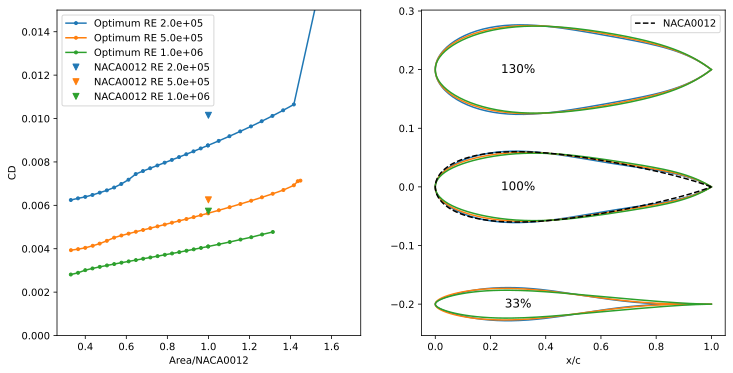

In [9]:
fig, ax = plt.subplots(1,2)
counter = 0
for RE in results.keys():
    order = np.argsort(results[RE]["Area"])
    ax[0].plot(results[RE]["Area"][order]/Area0,results[RE]["Drag"][order],'.-',label="Optimum RE %1.1e"%RE)
    ax[1].set_prop_cycle(None)
    for k in range(3):
        if k==0: # First non-nan
            index = 0
        elif k==1: # Closest to 1
            index = np.nanargmin(abs(results[RE]["Area"][order]/Area0-1.0))
        else: # Closest to 1.3
            index = np.nanargmin(abs(results[RE]["Area"][order]/Area0-1.3))
        [_,_,_,Shape] = dDeltadParamSymmetric(results[RE]["X"][:,order[index]],N,BaseAirfoil,False)
        ax[1].plot(Shape[0,:],Shape[1,:]+(k-1)*0.2,color = "C%u"%counter)

    counter+=1
    
ax[0].set_prop_cycle(None)
# Add simple NACA solution
for RE in results.keys():
    setup.Re = RE
    (p,bl,x) = vf.init(BaseAirfoil,setup)
    vf.iter(x,bl,p,setup)
    ax[0].plot(1.0,bl[0].CD,'v',label="NACA0012 RE %1.1e"%RE)
       
ax[1].text(.3, .2, '130%', fontsize = 12,ha='center', va='center')
ax[1].text(.3, 0, '100%', fontsize = 12,ha='center', va='center')
ax[1].text(.3, -.2, '33%', fontsize = 12,ha='center', va='center') 
ax[1].plot(BaseAirfoil[0,:],BaseAirfoil[1,:],'--k',label='NACA0012')

ax[0].set_ylim([0,0.015])
ax[0].set_xlabel('Area/NACA0012')
ax[0].set_ylabel('CD')
ax[1].set_xlabel('x/c')
ax[0].legend()
ax[1].legend()

The higher the Reynolds Number, the smaller the leading-edge radius and the more area is put aft.
It seems more difficult to solve for the optimum at higher Reynolds Numbers, in fact all optimization runs stop at some area between 1.4 and 1.6 times the NACA0012 area. 
Which is why the plots on the right show not the maximum area solution, but the 30% more solution.

Interestingly, the improvement of drag from the starting airfoil is similar for the lowest and highest Reynolds Number, while for 5e5 the improvement seems to be only a third compared to the others.

[1] Drela, Mark. *Pros and cons of airfoil optimization.* Frontiers of computational fluid dynamics 1998 (1998): 363-381.

[2] Sobieczky, Helmut. *Parametric airfoils and wings.* Recent development of aerodynamic design methodologies. Vieweg+ Teubner Verlag, 1999. 71-87.

[3] Yu, J. C., and R. Wulandari. *Airfoil aerodynamics optimization under uncertain operating conditions.* Journal of Physics: Conference Series. Vol. 1446. No. 1. IOP Publishing, 2020.

[4] Della Vecchia, Pierluigi, Elia Daniele, and Egidio DʼAmato. *An airfoil shape optimization technique coupling PARSEC parameterization and evolutionary algorithm.* Aerospace Science and Technology 32.1 (2014): 103-110.

[5] Drela, Mark. *XFOIL: An analysis and design system for low Reynolds number airfoils.* Low Reynolds number aerodynamics. Springer, Berlin, Heidelberg, 1989. 1-12.